# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

from os import makedirs
from os.path import dirname, basename, exists, isdir
import glob as glob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# List of paths to the first level output
bucket_path = sorted(glob.glob('/data/bswift-1/Pessoa_Lab/MAX/dataset/neutral_runs/MAX???/ROI_analysis/MAX???_Main_block_Deconv_bucket.1D'))

In [3]:
print('Number of subjects: ',len(bucket_path))

Number of subjects:  109


In [4]:
# List of ROIs
rois = ['ACC','vmPFC','Right PAG','Left PAG','Right BST','Left BST',
        'Right Ventral Striatum','Left Ventral Striatum','Right Posterior Putamen',
        'Left Posterior Putamen','Right Anterior Putamen','Left Anterior  Putamen',
        'Right Posterior Caudate','Left Posterior Caudate', 'Right Anterior Caudate',   
        'Left Anterior Caudate','Right AntVentral Insula','Right MidPost Insula',
        'Left AntVentral Insula','Left MidPost Insula','Right AntDorsal Insula',
        'Left AntDorsal Insula','Right CeMe Amygdala','Left CeMe Amygdala',
        'Right BLBM Amygdala','Left BLBM Amygdala','PCC','PCC/precuneus',
        'Left Posterior Thalamus','Right Posterior Thalamus','Left Anterior MCC',
        'Right Anterior MCC','Left Anterior Thalamus','Right Anterior Thalamus',
        'Left Hypothalamus','Right Hypothalamus']
for i,roi in enumerate(rois,start=1):
    print(i,roi)

1 ACC
2 vmPFC
3 Right PAG
4 Left PAG
5 Right BST
6 Left BST
7 Right Ventral Striatum
8 Left Ventral Striatum
9 Right Posterior Putamen
10 Left Posterior Putamen
11 Right Anterior Putamen
12 Left Anterior  Putamen
13 Right Posterior Caudate
14 Left Posterior Caudate
15 Right Anterior Caudate
16 Left Anterior Caudate
17 Right AntVentral Insula
18 Right MidPost Insula
19 Left AntVentral Insula
20 Left MidPost Insula
21 Right AntDorsal Insula
22 Left AntDorsal Insula
23 Right CeMe Amygdala
24 Left CeMe Amygdala
25 Right BLBM Amygdala
26 Left BLBM Amygdala
27 PCC
28 PCC/precuneus
29 Left Posterior Thalamus
30 Right Posterior Thalamus
31 Left Anterior MCC
32 Right Anterior MCC
33 Left Anterior Thalamus
34 Right Anterior Thalamus
35 Left Hypothalamus
36 Right Hypothalamus


In [5]:
def make_df(subj,vals,index,columns):
    '''
    Takes ROIs response estimates (or their associated variance) of subject subj and creates a dataframe  
    '''
    safe = pd.DataFrame(vals[:,:17],index=rois,columns=t).T
    safe['Type'] = 'safe'
    threat = pd.DataFrame(vals[:,17:34],index=rois,columns=t).T
    threat['Type'] = 'threat'
    tmp_df = pd.concat([threat,safe])
    tmp_df['Subj'] = subj
    tmp_df.index.name = 'Time'
    tmp_df.reset_index(inplace=True)
    return tmp_df

In [6]:
t = np.arange(17)*1.25
if exists('data/MAX_neutral_estimated_response.txt'):
    df = pd.read_csv('data/MAX_neutral_estimated_response.txt')
else:
    makedirs('data',exist_ok=True)
    df = pd.DataFrame()
    for path in bucket_path:
        subj = basename(path).split('_')[0]

        beta = np.loadtxt(path)[:len(rois),1::2]
        tstat = np.loadtxt(path)[:len(rois),2::2]

        var = (beta/tstat)**2

        tmp_df_beta = make_df(subj,beta,index=rois,columns=t)
        tmp_df_beta = pd.melt(tmp_df_beta,
                              id_vars=['Subj','Type','Time'],
                              var_name='ROI',
                              value_name='beta')
        tmp_df_var = make_df(subj,var,index=rois,columns=t)
        tmp_df_var = pd.melt(tmp_df_var,
                              id_vars=['Subj','Type','Time'],
                              var_name='ROI',
                              value_name='var')
        tmp_df = pd.merge(tmp_df_beta,tmp_df_var)

        df = pd.concat([df,tmp_df],ignore_index=True)
    df.to_csv('data/MAX_neutral_estimated_response.txt',sep=',',index=False,float_format='%0.4f')

In [7]:
from scipy.stats import sem
from scipy.stats import t as tdist
N = len(bucket_path)
critT = tdist(df=N-1).ppf(0.975)

In [8]:
df.head()

,Subj,Type,Time,ROI,beta,var
0,MAX101,threat,0.00,ACC,-0.0494,0.0040
1,MAX101,threat,1.25,ACC,-0.0880,0.0051
2,MAX101,threat,2.50,ACC,-0.0611,0.0059
3,MAX101,threat,3.75,ACC,-0.0318,0.0063
4,MAX101,threat,5.00,ACC,0.0947,0.0066


In [9]:
mean_df = df.groupby(['Type','ROI','Time'])['beta'].agg([np.mean,sem]).reset_index()

In [10]:
mean_df['lower_bound'] = mean_df['mean'] - critT*mean_df['sem']
mean_df['upper_bound'] = mean_df['mean'] + critT*mean_df['sem']

In [11]:
mean_df.head()

,Type,ROI,Time,mean,sem,lower_bound,upper_bound
0,safe,ACC,0.00,-0.017714,0.010467,-0.038461,0.003033
1,safe,ACC,1.25,-0.042335,0.012918,-0.067941,-0.016729
2,safe,ACC,2.50,-0.027290,0.017202,-0.061388,0.006808
3,safe,ACC,3.75,-0.015686,0.018015,-0.051396,0.020024
4,safe,ACC,5.00,-0.009466,0.018704,-0.046540,0.027608


## Estimated Response plot (varying y-axis range)

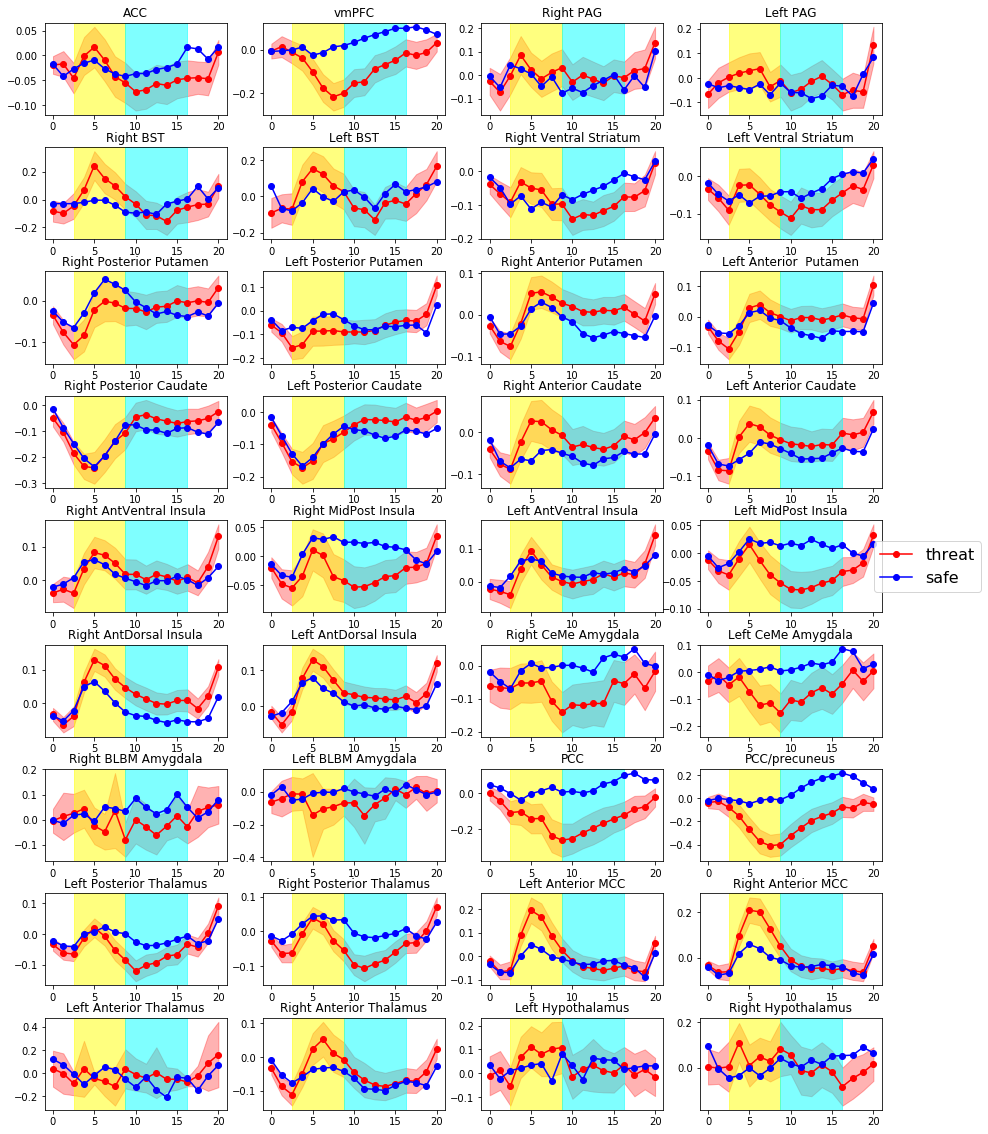

In [12]:
fig, axes = plt.subplots(nrows=9,ncols=4,figsize=(15,20),sharey=False)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.2,hspace=0.35)

for i, roi in enumerate(rois):
    threat_df = mean_df[(mean_df['ROI']==roi) & (mean_df['Type']=='threat')]
    safe_df = mean_df[(mean_df['ROI']==roi) & (mean_df['Type']=='safe')]
    axes[i].plot(t,threat_df['mean'],label='threat',color='red',marker='o')
    axes[i].fill_between(t,threat_df['lower_bound'],threat_df['upper_bound'],alpha=0.3,color='red')
    axes[i].plot(t,safe_df['mean'],label='safe',color='blue',marker='o')
    #axes[i].fill_between(t,safe_df['lower_bound'],safe_df['upper_bound'],alpha=0.3,color='blue')
    axes[i].axvspan(xmin=2.5,xmax=8.75,color='yellow',alpha=0.5)
    axes[i].axvspan(xmin=8.75,xmax=16.25,color='cyan',alpha=0.5)
    axes[i].set_title(roi)
fig.legend(axes[i].get_legend_handles_labels()[1],loc='center right',fontsize=16)

## Estimated Response plot (fixed y-axis range)

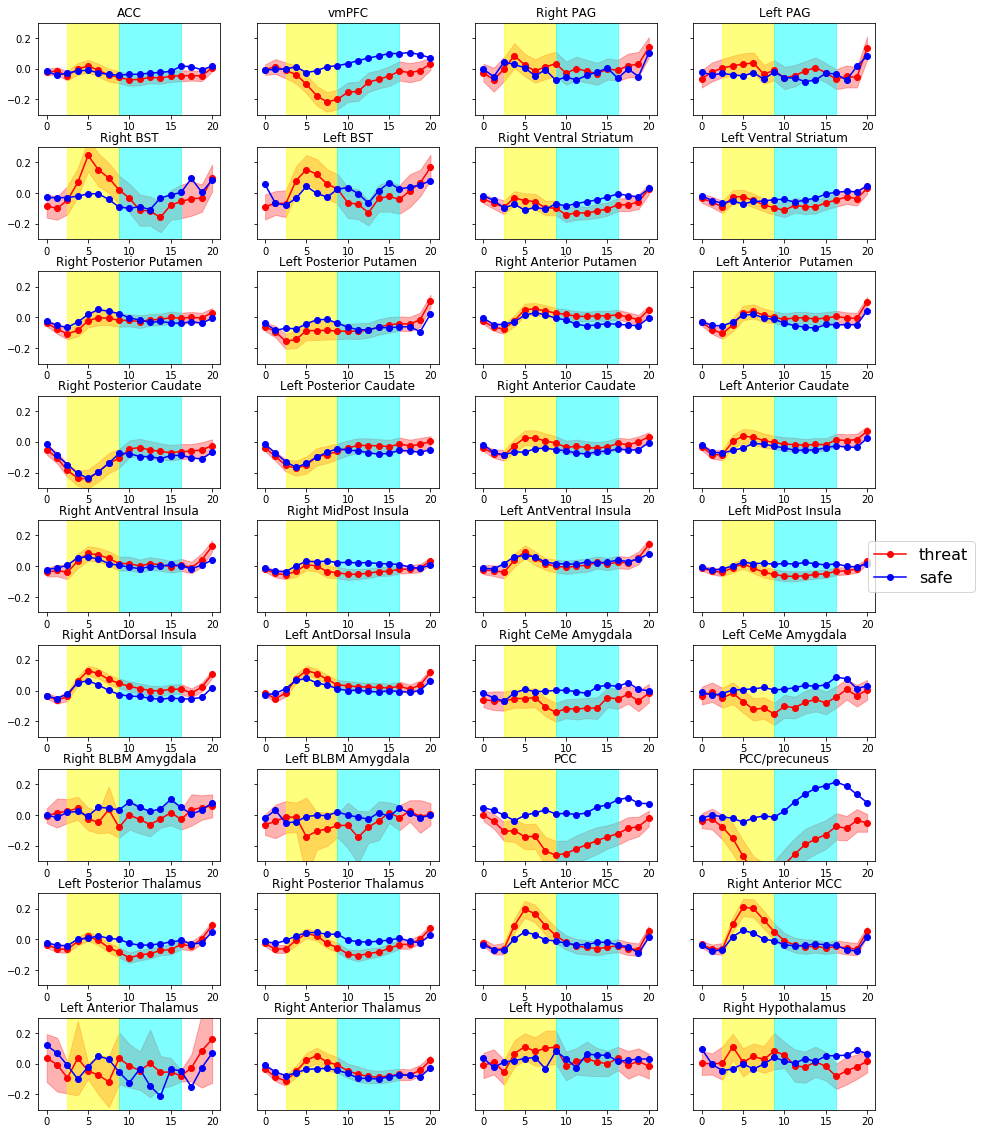

In [13]:
fig, axes = plt.subplots(nrows=9,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.2,hspace=0.35)

for i, roi in enumerate(rois):
    threat_df = mean_df[(mean_df['ROI']==roi) & (mean_df['Type']=='threat')]
    safe_df = mean_df[(mean_df['ROI']==roi) & (mean_df['Type']=='safe')]
    axes[i].plot(t,threat_df['mean'],label='threat',color='red',marker='o')
    axes[i].fill_between(t,threat_df['lower_bound'],threat_df['upper_bound'],alpha=0.3,color='red')
    axes[i].plot(t,safe_df['mean'],label='safe',color='blue',marker='o')
    #axes[i].fill_between(t,safe_df['lower_bound'],safe_df['upper_bound'],alpha=0.3,color='blue')
    axes[i].axvspan(xmin=2.5,xmax=8.75,color='yellow',alpha=0.5)
    axes[i].axvspan(xmin=8.75,xmax=16.25,color='cyan',alpha=0.5)
    axes[i].set_title(roi)
    axes[i].set_ylim([-0.3,0.3])
fig.legend(axes[i].get_legend_handles_labels()[1],loc='center right',fontsize=16)

## STAI scores

In this section, STAI scores are standardized and added to the dataset

In [14]:
import re

STAI_path = '/data/bswift-1/Pessoa_Lab/MAX/June2020/dataset/behavioral/STAI_sums'
 
with open(STAI_path,'r') as file:
    names = re.split('\t| |\n',file.readline())

STAI=pd.read_csv(STAI_path,sep='\t',names=names[:3],skiprows=1)
STAI['Subj'] = STAI['subject'].apply(lambda ID: 'MAX{:03d}'.format(ID))
STAI.drop('subject',axis=1,inplace=True)
STAI = STAI[STAI.Subj.isin(df.Subj)]
STAI.set_index('Subj',inplace=True)
STAI.head()

,TRAIT,STATE
Subj,,
MAX101,27,22
MAX102,47,44
MAX103,33,32
MAX104,24,21
MAX105,56,28


In [15]:
# Standardize the covariates
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
STAI = pd.DataFrame(ss.fit_transform(STAI),columns=STAI.columns,index=STAI.index)
STAI.reset_index(inplace=True)
STAI.head()

,Subj,TRAIT,STATE
0,MAX101,-1.164152,-1.011495
1,MAX102,1.264414,1.539046
2,MAX103,-0.435582,0.147842
3,MAX104,-1.528437,-1.127429
4,MAX105,2.357268,-0.315893


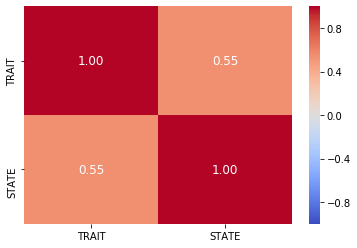

In [16]:
# Trait-State correlation 
_=sns.heatmap(STAI.corr(method='spearman'),vmin=-1,vmax=1,annot=True,fmt='.2f',cmap='coolwarm',annot_kws=dict(size=12))

## Aggregate Early/Late Periods 

This notebook aggregates responses from early (2.5-8.75s) and late periods (10-16.25s)

In [17]:
def phase(time):
    if (time >= 2.5 and time <= 8.75):
        return 'early'
    elif (time >= 10 and time <= 16.25):
        return 'late'
    else:
        return np.nan

In [18]:
# Add a phase column (early.late)
df['Phase'] = df['Time'].apply(phase)
df.dropna(inplace=True)
df.head()

,Subj,Type,Time,ROI,beta,var,Phase
2,MAX101,threat,2.50,ACC,-0.0611,0.0059,early
3,MAX101,threat,3.75,ACC,-0.0318,0.0063,early
4,MAX101,threat,5.00,ACC,0.0947,0.0066,early
5,MAX101,threat,6.25,ACC,0.0330,0.0068,early
6,MAX101,threat,7.50,ACC,-0.0339,0.0070,early


In [19]:
# Function to aggregation responses by taking weighted average
def combine_beta(row):
    beta = row.iloc[:,0]
    var = row.iloc[:,1]
    weights = 1/var
    combined_beta = np.sum(weights*beta)/np.sum(weights)
    combined_var = 1/np.sum(weights)
    return combined_beta , combined_var

In [20]:
agg_df = df.groupby(['Subj','Type','ROI','Phase'])[['beta','var']].apply(combine_beta)
agg_df = agg_df.to_frame(name=('betavar')).reset_index()
agg_df[['beta', 'var']] = pd.DataFrame(agg_df['betavar'].tolist(), index=agg_df.index)
agg_df.drop('betavar',axis=1,inplace=True)
agg_df = agg_df.merge(STAI)
agg_df.head()

,Subj,Type,ROI,Phase,beta,var,TRAIT,STATE
0,MAX101,safe,ACC,early,-0.008450,0.001131,-1.164152,-1.011495
1,MAX101,safe,ACC,late,-0.042602,0.001172,-1.164152,-1.011495
2,MAX101,safe,Left AntDorsal Insula,early,-0.048800,0.000889,-1.164152,-1.011495
3,MAX101,safe,Left AntDorsal Insula,late,-0.085116,0.000897,-1.164152,-1.011495
4,MAX101,safe,Left AntVentral Insula,early,-0.129348,0.001908,-1.164152,-1.011495


In [21]:
agg_df['cond'] = agg_df['Type'].apply(lambda a: -0.5 if a=='safe' else 0.5)
agg_df['LvsE'] = agg_df['Phase'].apply(lambda a: -0.5 if a=='early' else 0.5)
agg_df.head()

,Subj,Type,ROI,Phase,beta,var,TRAIT,STATE,cond,LvsE
0,MAX101,safe,ACC,early,-0.008450,0.001131,-1.164152,-1.011495,-0.5,-0.5
1,MAX101,safe,ACC,late,-0.042602,0.001172,-1.164152,-1.011495,-0.5,0.5
2,MAX101,safe,Left AntDorsal Insula,early,-0.048800,0.000889,-1.164152,-1.011495,-0.5,-0.5
3,MAX101,safe,Left AntDorsal Insula,late,-0.085116,0.000897,-1.164152,-1.011495,-0.5,0.5
4,MAX101,safe,Left AntVentral Insula,early,-0.129348,0.001908,-1.164152,-1.011495,-0.5,-0.5


In [22]:
if not exists('data/MAX_neutral_early_late.txt'):
    agg_df.to_csv('data/MAX_neutral_early_late.txt',sep=',',float_format='%.6f',index=False)